<a href="https://colab.research.google.com/github/EmYassir/rl_optimal_control/blob/main/free-flying_robot_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the Free-Flying Robot Problem via Trapezoidal Collocation

### Sources

1. J. T. BETTS, Practical methods for optimal control using nonlinear programming, Soc. for Industrial and Applied Mathematics, (2001), Philadelphia, PA.

2. Y. SAKAWA, Trajectory Planning of a Free-Flying Robot by Using the Optimal Control, Optimal Control Applications and Methods, 20 (1999), pp. 235–248.

The Free-Flying Robot Problem is found in *Chapter 6: Optimal Control Examples* of Betts' book, in section 6.13, where it is in turn sourced from Sakawa's paper. This implementation is based on the problem formulation presented in Betts' book. The illustrations used, unless cited otherwise, are taken from Sakawa's paper.



### Problem Description

The problem describes the motion of a free-flying robot equipped with a propulsion system. The robot's aim is to move from $x_{t_0}=(x_{1, t_0}, x_{2, t_0})$ to $x_{t_f}=(x_{1, t_f}, x_{2, t_f})$ with minimum fuel used, which is represented by the propulsion force used, which will constitute our control variables.

### States

The robot's state at any given point is given by: 
$$\mathbf{y} = (x_1,x_2, \theta, v_1, v_2, \omega)$$

$(x_1, x_2)$: center of gravity of the robot, aka position

$\theta$: thrust direction

$(v_1, v_2)$: velocity of the robot, corresponding to theposition variables 

$\omega$: angular velocity

The initial state boundary conditions are:
$$\mathbf{y}(0) = (-10, -10, \frac{\pi}{2}, 0, 0, 0)$$

The final state boundary conditions are:
$$\mathbf{y}(t_f) = (0, 0, 0, 0, 0, 0)$$

To interpret these in words, we want our robot to start from in position $(-10, -10)$, where it is in standstill with a 90 degree angle (vertically), and move to $(0, 0)$ and come to a standstill there in horizontal position. Sakawa illustrates this as:

![](https://drive.google.com/uc?export=view&id=1ghX0wxQ0YNH804ZrRFdAmHV-U-s2nF5y)

### Controls

Our robot comes with two thrusters, $T_1$ and $T_2$, which serve as our control variables. At any given time $t$, the thrusters have the bounds:
$$\vert T_1(t) \vert \leq 1, \quad \vert T_2(t) \vert \leq 1$$

Sakawa illustrates the states and controls on the robot as follows:

![](https://drive.google.com/uc?export=view&id=1ig3YK_CsWL7oXLBFkTHdSGoDcGH0Sk73)

### Cost Function

The Betts' book slightly simplifies the cost function in Sakawa's paper, and defines it only in terms of the control variables. In our problem setting, the cost is defined as the fuel used, interpreted as the total "usage" of the thrusters - so more thruster usage (aka force applied) means more fuel used. This allows us to define our cost function as:

$$\gamma \int_{t_0}^{t_f} (\vert T_1 \vert + \vert T_2 \vert) dt$$

Our problem setting defines $\gamma=1$, $t_0=0$ and $t_f = 12$, and our cost function becomes:

$$\int_0^{12} (\vert T_1 \vert + \vert T_2 \vert) dt$$

The book notes the following:

> Unfortunately, the objective function as written has discontinuous derivatives because
it involves the absolute value function.

It then proceeds to decompose $T_1$ and $T_2$ to its positive and negative components, which enables working around the discontinuities when integarating over the cost function. However, as we approximate the integral through trapezoidal quadrature and do not need to explicitly derive or integrate, this approach is not neccesary.

### Dynamics

The dynamics proposed are as follows:

$$\dot{x_1} = v_1$$
$$\dot{x_2} = v_2$$
$$\dot{\theta} = \omega$$
$$\dot{v_1} = [T_1 + T_2] \cos\theta$$
$$\dot{v_2} = [T_1 + T_2] \sin\theta$$
$$\dot{\omega} = \alpha T_1 - \beta T_2$$

In our problem setting, $\alpha = \beta = 0.2$.

## Implementation

In [ ]:
import numpy as onp
from scipy.optimize import minimize

import jax
import jax.numpy as np
from jax.flatten_util import ravel_pytree

from jax.config import config
config.update("jax_enable_x64", True)

In [ ]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.dpi'] = 200

We implement the system dynamics as:

In [ ]:
def free_flying_robot_problem(alpha=0.2, beta=0.2):
    def fun(state, control):
        x_1, x_2, theta, v_1, v_2, omega = state
        T_1, T_2 = control

        a_1 = (T_1 + T_2) * np.cos(theta)
        a_2 = (T_1 + T_2) * np.sin(theta)
        a_ang = alpha * T_1 - beta * T_2

        return np.asarray([v_1, v_2, omega, a_1, a_2, a_ang])
    return fun

We have the cost function as:

$$\int_{t_0}^{t_f} (\vert T_1 \vert + \vert T_2 \vert) dt$$

with $t_0=0$ and $t_f = 12$. Our initial boundary conditions are:

$$\mathbf{y}(0) = (-10, -10, \frac{\pi}{2}, 0, 0, 0)$$

In [ ]:
t_start, t_end = 0., 12.
t_span = [t_start, t_end]
initial_conditions = np.array([-10., -10., np.pi/2, 0, 0, 0])

We here define a plotting function in order to plot all states and controls. Given the number of states/controls, it's bound to be a crowded plot, so we will later define a generic plotting function to print only the desired variables.

In [ ]:
def plot_flying_robot(times, states, controls):
  fig, ax = plt.subplots()
  ax.grid(True, alpha=0.2)
  ax.set_xlim(0, 12)
  ax.set_xlabel('Time')
  ax.set_title("Free-Flying Robot Problem")

  ax.plot(times, states[:, 0], c='tab:green', label='Center of Gravity 1')
  ax.plot(times, states[:, 1], c='tab:olive', label='Center of Gravity 2')
  ax.plot(times, controls[:, 0],  c='tab:red', label='Control 1')
  ax.plot(times, controls[:, 1], c='tab:orange', label='Control 2')
  ax.plot(times, states[:, 3], c='tab:blue', label='Velocity 1')
  ax.plot(times, states[:, 4],  c='tab:cyan', label='Velocity 2')
  ax.legend()

  rhs_ax = ax.twinx()
  rhs_ax.plot(times, np.rad2deg(states[:, 2]), c='tab:purple', linestyle='dashed', label='Angle')
  rhs_ax.plot(times, np.rad2deg(states[:, 5]), c='tab:pink', linestyle='dashed', label='Angular Velocity')
  rhs_ax.tick_params(axis='y', labelcolor='tab:purple')
  rhs_ax.set_ylabel('Angle (deg)', color='tab:purple')
  rhs_ax.legend()

  plt.show()

Let's test two scenarios - In the first, we just use only the first thruster $T_1$ at full force. We see that the angle increases rapidly as the robot revolves around its own axis with linearly increasing angular velocity, while the velocity components oscillate as a result. We also see that using a single thruster means moving in the positive direction in one directional axis ($x_2$) and in negative direction in the other ($x_1$).

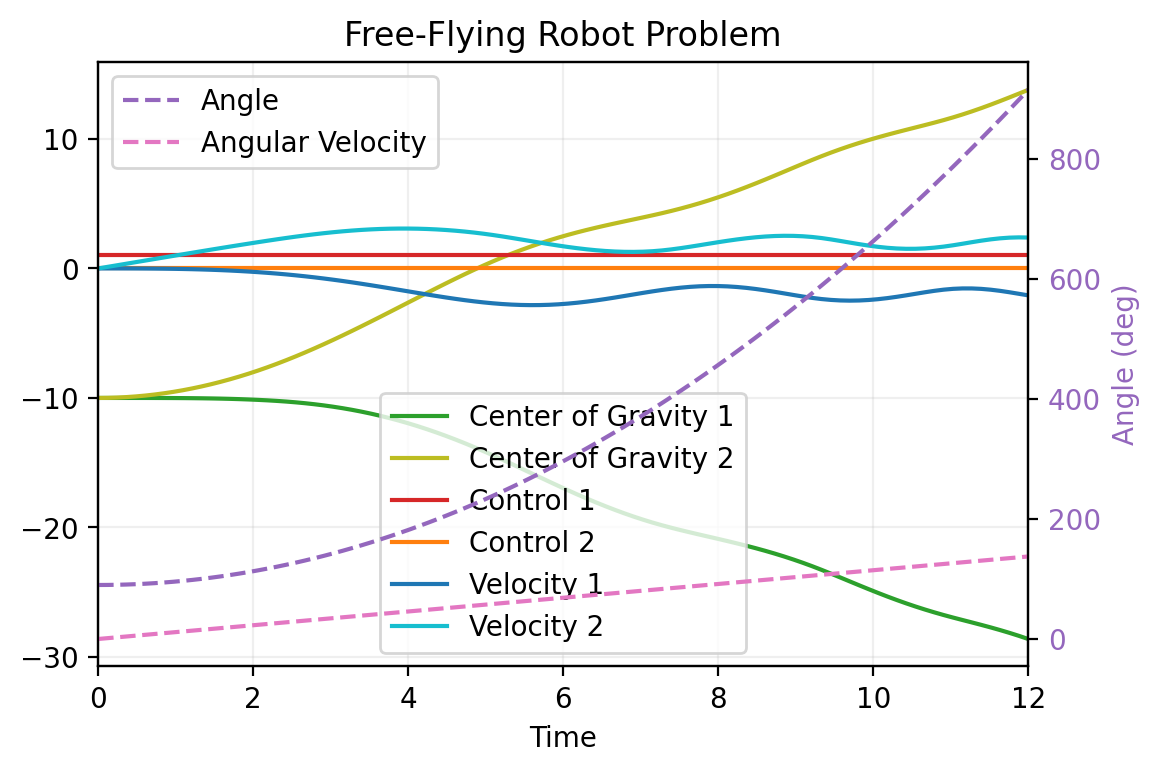

In [ ]:
from scipy.integrate import solve_ivp 

fun = free_flying_robot_problem()

npoints = 100
fixed_force = np.array([1, 0])
solution = solve_ivp(lambda t, x: fun(x, fixed_force), t_span, initial_conditions, t_eval=np.linspace(*t_span, npoints))
plot_flying_robot(solution.t, solution.y.T, fixed_force*np.ones((npoints, 2)))

The period of oscillations in velocity get shorter and the velocity converges in time as angular velocity increases - we can test this by applying a thruster force of 10 (which is normally out of bounds):

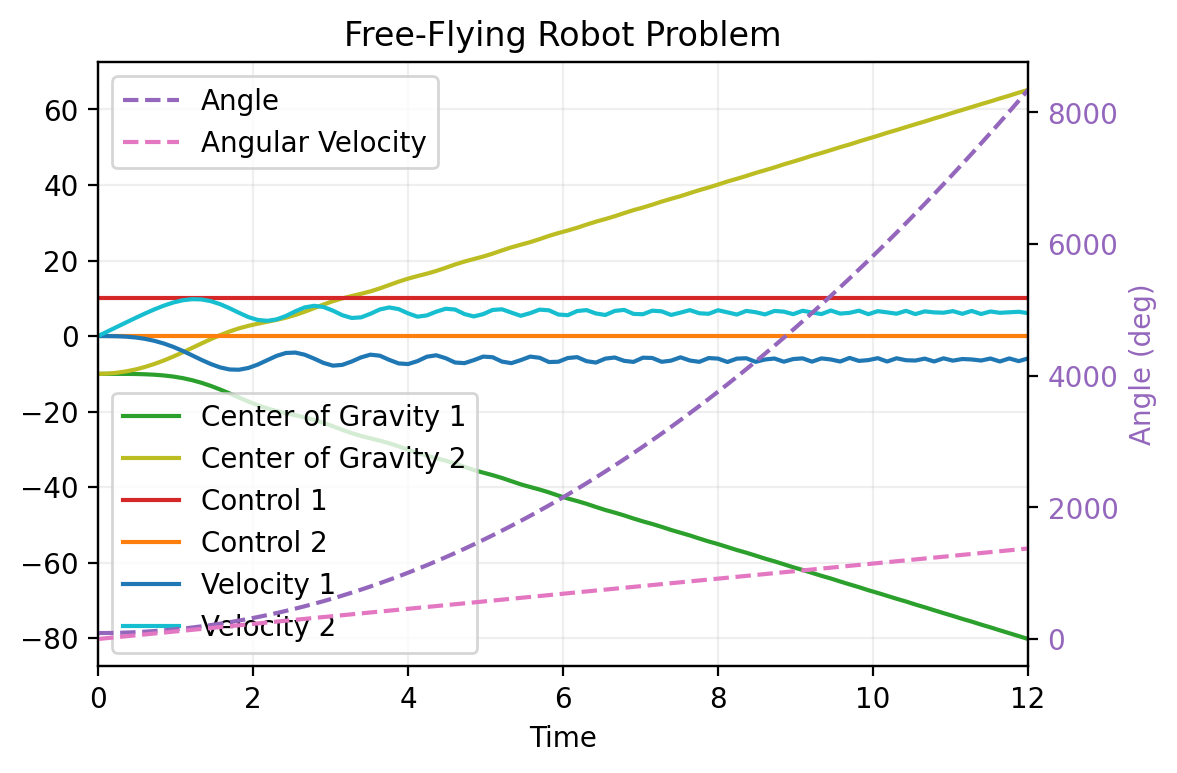

In [ ]:
from scipy.integrate import solve_ivp 

fun = free_flying_robot_problem()

npoints = 100
fixed_force = np.array([10, 0])
solution = solve_ivp(lambda t, x: fun(x, fixed_force), t_span, initial_conditions, t_eval=np.linspace(*t_span, npoints))
plot_flying_robot(solution.t, solution.y.T, fixed_force*np.ones((npoints, 2)))

Any application of a fixed force in either thruster will result in a similar pattern. For example, applying both thrusters at full force will simply move the robot vertically in the y-axis:

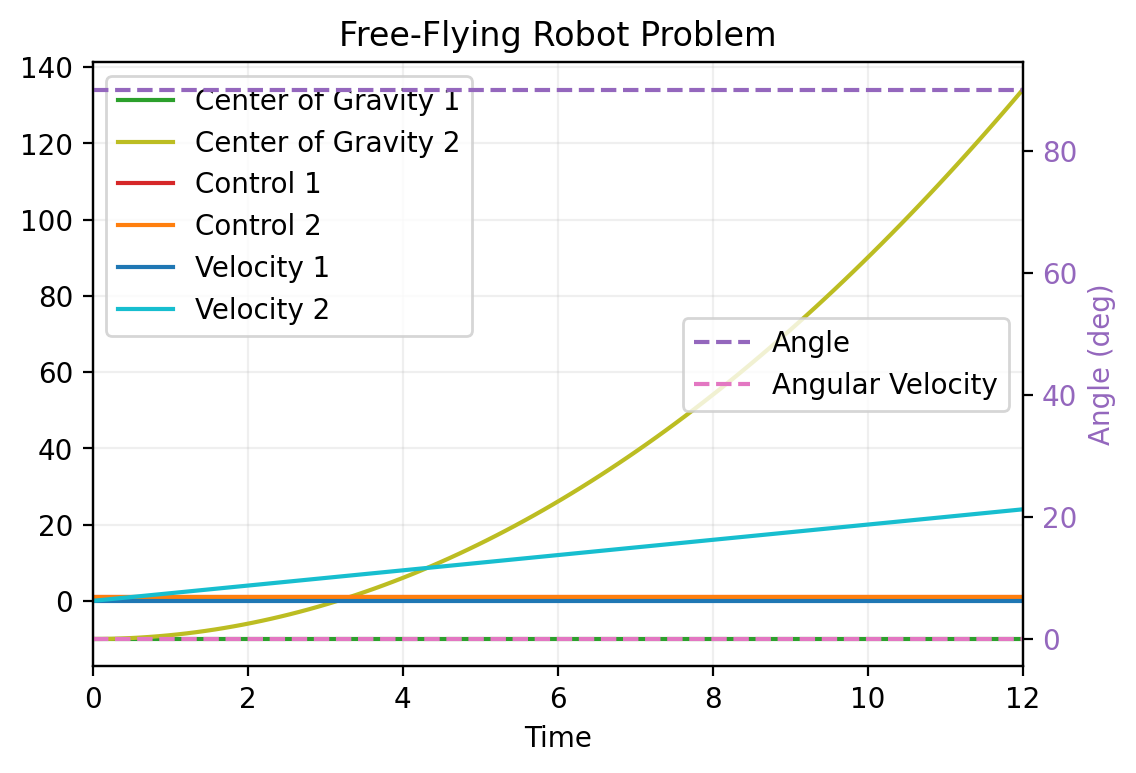

In [ ]:
fixed_force = np.array([1, 1])
solution = solve_ivp(lambda t, x: fun(x, fixed_force), t_span, initial_conditions, t_eval=np.linspace(*t_span, npoints))
plot_flying_robot(solution.t, solution.y.T, fixed_force*np.ones((npoints, 2)))

# Solving the Problem with Direct Transcription via Collocation

Now that we have visualized some examples of the system in action, let's solve this problem. We use the previously defined cost function, and define the trapezoidal defect and cost according to trapezoidal collocation and trapezoidal quadrature rules respectively. We also define the bounds for state and control for the system here, which will then be entered into the minimize() function.

Note that trapezoidal collocation is just one way of solving this problem via collocation. We could also use other direct transcription methods such as Hermite-Simpson collocation, and the accuracy can be improved via using higher-order polynomial basis functions.

In [ ]:
def make_nlp(horizon, nintervals, unravel):
    nvars = nintervals + 1
    interval_duration = horizon/nintervals

    f = free_flying_robot_problem()

    def cost(x, u):
        return np.abs(u[0]) + np.abs(u[1])

    def trapezoid_defect(state, next_state, control, next_control):
        f_start = f(state, control)
        f_end = f(next_state, next_control)
        return next_state - state - interval_duration/2 * (f_start + f_end)

    def trapezoid_cost(state, next_state, control, next_control):
        cost_current = cost(state, control)
        cost_next = cost(next_state, next_control)
        return interval_duration * (cost_current + cost_next) / 2

    batched_cost = jax.vmap(trapezoid_cost)
    batched_defects = jax.vmap(trapezoid_defect)

    def objective(flat_variables):
        states, controls = unravel(flat_variables)
        return np.sum(batched_cost(states[:-1], states[1:], controls[:-1], controls[1:]))

    def equality_constraints(flat_variables):
        states, controls = unravel(flat_variables)
        return np.ravel(batched_defects(states[:-1], states[1:], controls[:-1], controls[1:]))

    umax = 1
    state_bounds = onp.empty((nvars, 12))
    state_bounds[:, 0] = -onp.inf
    state_bounds[:, 1] = onp.inf
    state_bounds[:, 2] = -onp.inf
    state_bounds[:, 3] = onp.inf
    state_bounds[:, 4] = -onp.inf
    state_bounds[:, 5] = onp.inf
    state_bounds[:, 6] = -onp.inf
    state_bounds[:, 7] = onp.inf
    state_bounds[:, 8] = -onp.inf
    state_bounds[:, 9] = onp.inf
    state_bounds[:, 10] = -onp.inf
    state_bounds[:, 11] = onp.inf

    state_bounds[0, 0] = -10.
    state_bounds[0, 1] = -10.
    state_bounds[0, 2] = -10.
    state_bounds[0, 3] = -10.
    state_bounds[0, 4] = np.pi/2
    state_bounds[0, 5] = np.pi/2
    state_bounds[0, 6] = 0
    state_bounds[0, 7] = 0
    state_bounds[0, 8] = 0
    state_bounds[0, 9] = 0
    state_bounds[0, 10] = 0
    state_bounds[0, 11] = 0

    state_bounds[-1, :] = 0

    control_bounds = onp.empty((nvars, 4))
    control_bounds[:, 0] = -umax
    control_bounds[:, 1] = umax
    control_bounds[:, 2] = -umax
    control_bounds[:, 3] = umax

    return objective, equality_constraints, np.vstack(
        (np.reshape(state_bounds, (-1, 2)),
         np.reshape(control_bounds, (-1, 2))))

We use a linear interpolation between $x(t_0)$ and $x(t_f)$ as a guess...

In [ ]:
intervals = 20
nvars = intervals + 1

linear_interpolation = np.arange(nvars)/(nvars-1)
initial_states = np.tile(initial_conditions, (nvars, 1))
initial_states = linear_interpolation[:, np.newaxis] * initial_states
initial_variables = (initial_states, np.zeros((nvars, 2)))
flat_initial_variables, unravel = ravel_pytree(initial_variables)

... and solve the problem using SLSQP in scipy.optimize.minimize:

In [ ]:
objective, equality_constraints, bounds = make_nlp(t_end, intervals, unravel)
constraints = ({'type': 'eq',
                'fun': jax.jit(equality_constraints),
                'jac': jax.jit(jax.jacrev(equality_constraints))
                })
flat_onp = onp.asarray(flat_initial_variables)
bounds_onp = onp.asarray(bounds)
solution = minimize(fun=jax.jit(objective),
                    x0=flat_initial_variables,
                    method='SLSQP',
                    constraints=constraints,
                    bounds=bounds,
                    jac=jax.jit(jax.grad(objective)),
                    options={"disp": True, "maxiter": 5000})
solution.message

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.241925041789441
            Iterations: 148
            Function evaluations: 424
            Gradient evaluations: 148


'Optimization terminated successfully.'

The problem states that the optimal objective function is $F^*=7.910154646$. We have minimized the objective function to $8.242$, which is close, but not too great.

In [ ]:
states, controls = unravel(solution.x)
times = np.linspace(*t_span, nvars)

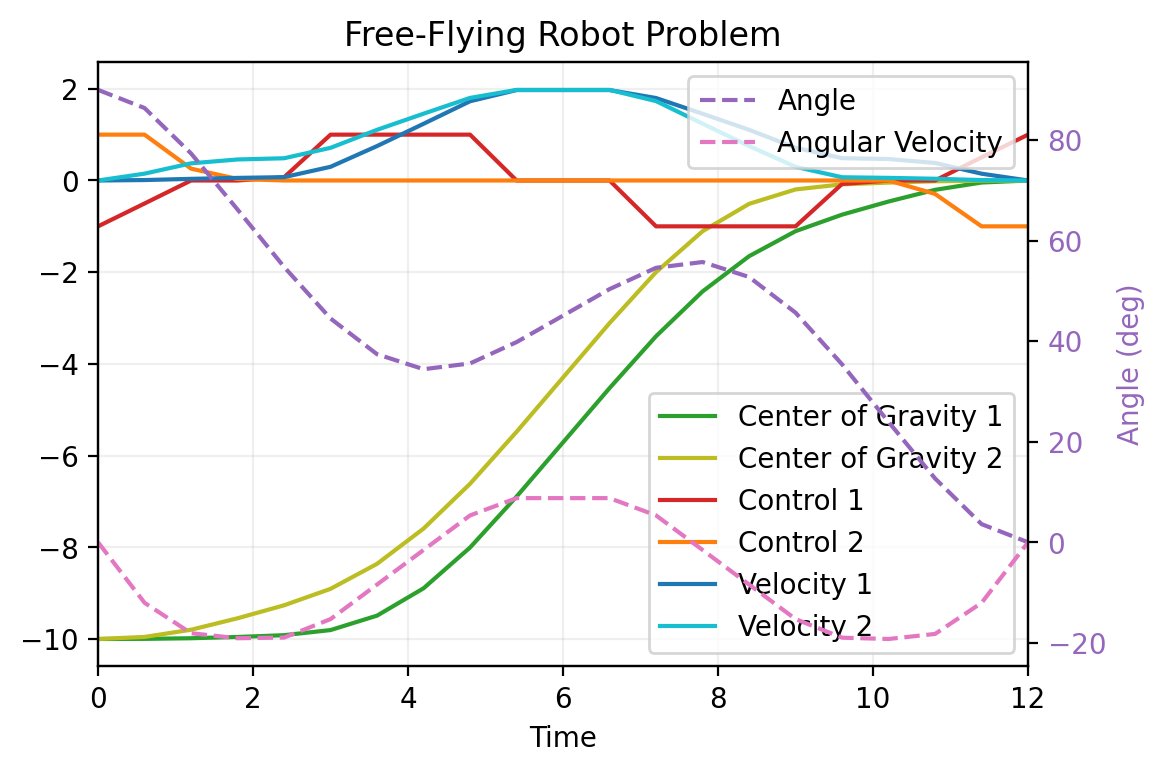

In [ ]:
plot_flying_robot(times, states, controls)

However, we see that the progression of states and controls resemble the solutions presented in Betts' book very closely. We will inspect them in more detail, but before we do that, let's see what happens if we increase the number of intervals to 40 in order to enable a better estimate:

In [ ]:
intervals = 40
nvars = intervals + 1

linear_interpolation = np.arange(nvars)/(nvars-1)
initial_states = np.tile(initial_conditions, (nvars, 1))
initial_states = linear_interpolation[:, np.newaxis] * initial_states
initial_variables = (initial_states, np.zeros((nvars, 2)))
flat_initial_variables, unravel = ravel_pytree(initial_variables)

In [ ]:
objective, equality_constraints, bounds = make_nlp(t_end, intervals, unravel)
constraints = ({'type': 'eq',
                'fun': jax.jit(equality_constraints),
                'jac': jax.jit(jax.jacrev(equality_constraints))
                })
flat_onp = onp.asarray(flat_initial_variables)
bounds_onp = onp.asarray(bounds)
solution = minimize(fun=jax.jit(objective),
                    x0=flat_initial_variables,
                    method='SLSQP',
                    constraints=constraints,
                    bounds=bounds,
                    jac=jax.jit(jax.grad(objective)),
                    options={"disp": True, "maxiter": 5000})
solution.message

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.994253372016384
            Iterations: 470
            Function evaluations: 964
            Gradient evaluations: 470


'Optimization terminated successfully.'

Much better! With $7.994$, we have reduced our error from $\frac{0.332}{7.91}=4.2\%$ to $\frac{0.084}{7.91}=1.06\%$, a significant improvement. While we will not compute with further intervals here interactively due to computation times, I have locally run with 100 intervals as well, which gave me an optimal value of $7.961$, with an impressively low error of $\frac{0.051}{7.91}=0.64\%$. As expected, our trapezoidal quadrature approximates the error better as the number of intervals increase, and we can expect this value converge to the *real* optimal value of $7.91$.

It should be noted that the state/control graphs resemble the optimal ones closely regardless, even when using just 20 intervals. For the following plots, we'll be using 40 intervals. Let's plot all variables at once again, and then define a generalized version of our plotting function:

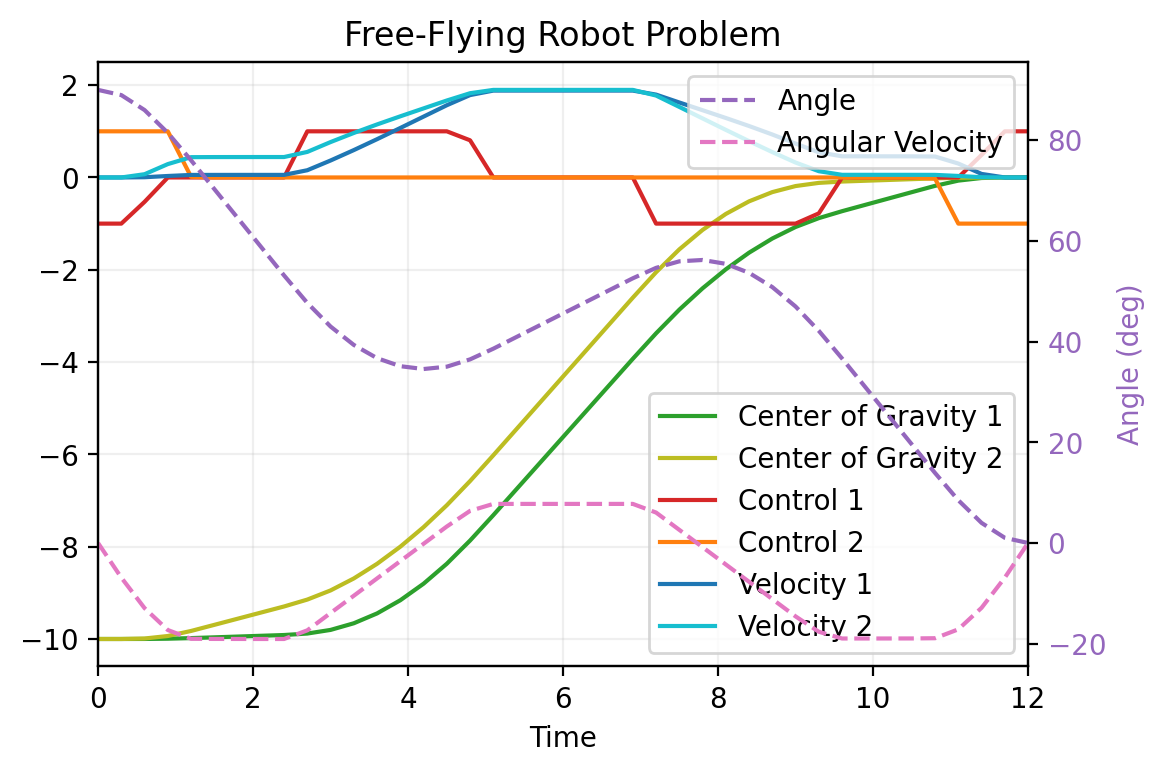

In [ ]:
states, controls = unravel(solution.x)
times = np.linspace(*t_span, nvars)
plot_flying_robot(times, states, controls)

In [ ]:
def plot_flying_robot_vars(times, states, controls, state_dict=None, control_dict=None, y_label=None):
    fig, ax = plt.subplots()
    ax.grid(True, alpha=0.2)
    ax.set_xlim(0, 12)
    ax.set_xlabel('Time')
    if y_label is not None:
        ax.set_ylabel(y_label)
    ax.set_title("Free-Flying Robot Problem")

    if state_dict is not None:
        for state_idx, state_label in state_dict:
            ax.plot(times, states[:, state_idx], label=state_label)

    if control_dict is not None:
        for control_idx, control_label in control_dict:
            ax.plot(times, controls[:, control_idx], label=control_label)

    ax.legend()
    plt.show()

We will now proceed to plot the variables in pairs for clarity. The solutions in Betts' book will also be attached under each section, further reinforcing that our solution is correct.

### State: Position/Center of Gravity

![](https://drive.google.com/uc?export=view&id=1dDixDwkkSPbHLOyfttrgD6r6QyTd_R74)

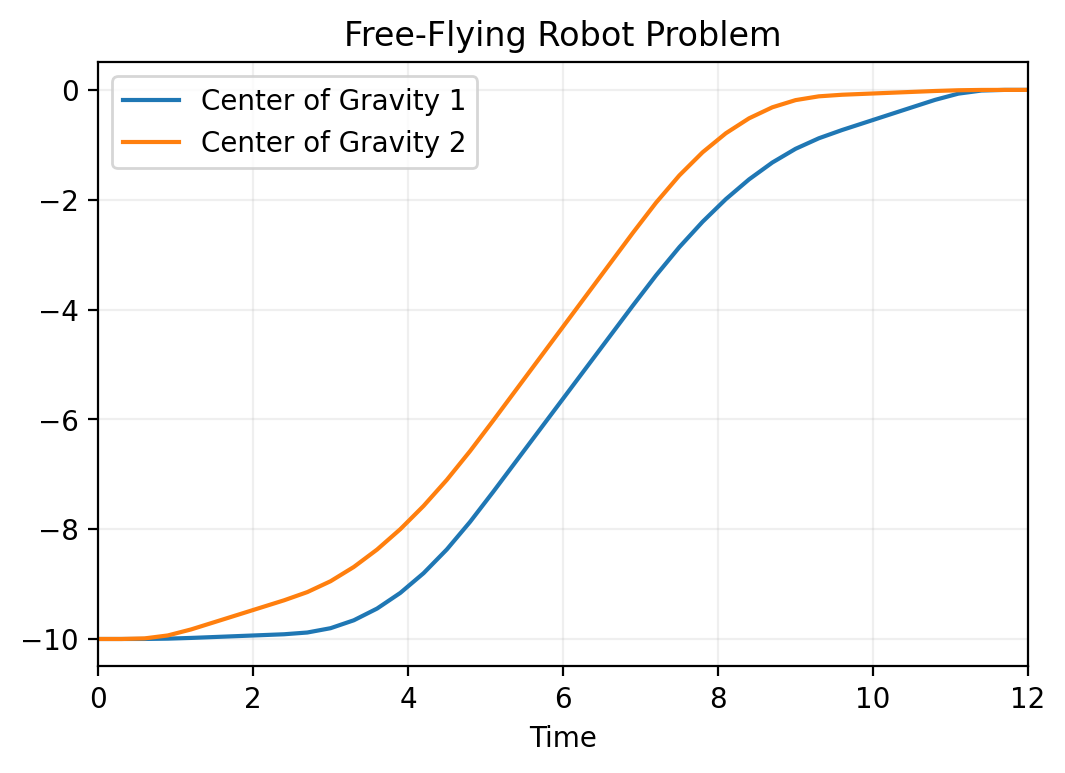

In [ ]:
state_dict = [(0, 'Center of Gravity 1'), (1, 'Center of Gravity 2')]
plot_flying_robot_vars(times, states, controls, state_dict)

### State: Velocity

![](https://drive.google.com/uc?export=view&id=1Fm9WXzDk-5fWVcQBNptL1sO2jewk8vs7)


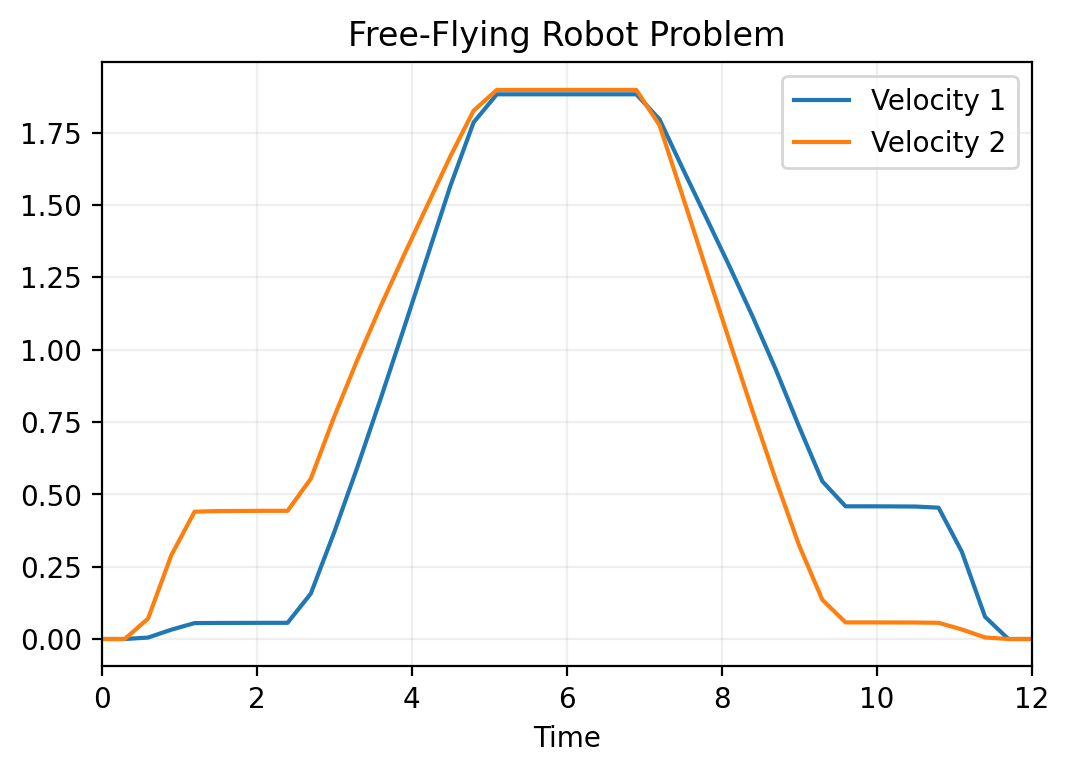

In [ ]:
state_dict = [(3, 'Velocity 1'), (4, 'Velocity 2')]
plot_flying_robot_vars(times, states, controls, state_dict)

### State: Angular Direction and Velocity

![](https://drive.google.com/uc?export=view&id=1_OAvIq-AjH27l5wL0xGeF8rd0dq_bhfJ)

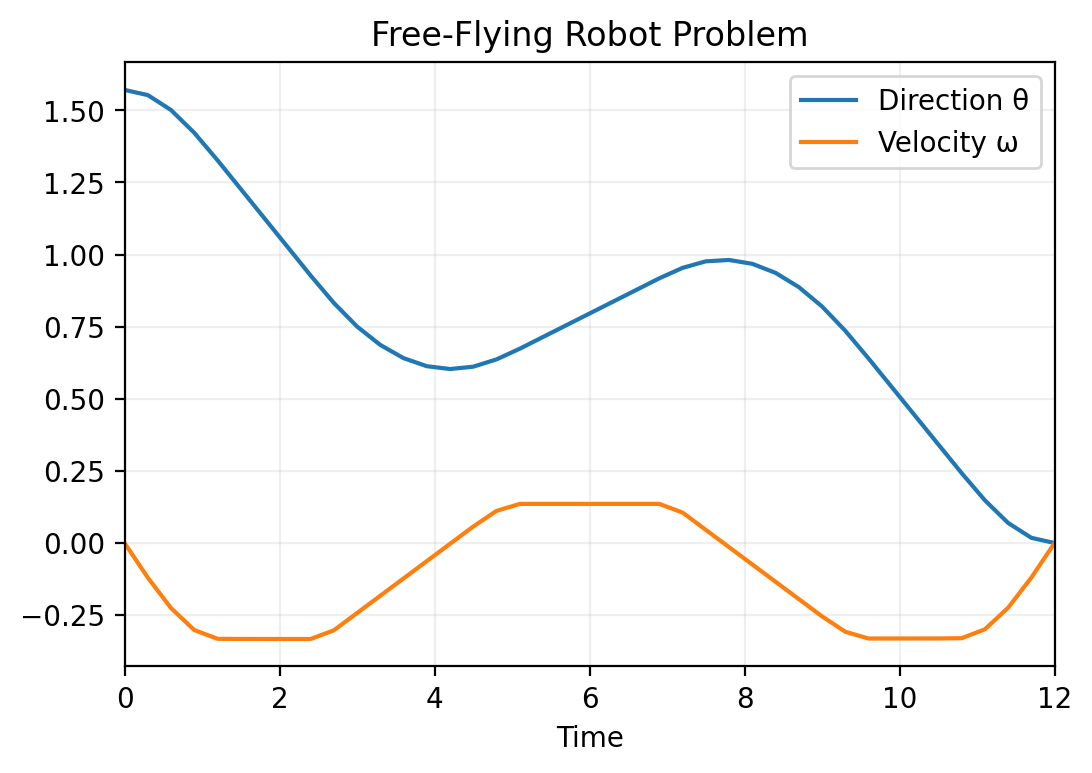

In [ ]:
state_dict = [(2, 'Direction θ'), (5, 'Velocity ω')]
plot_flying_robot_vars(times, states, controls, state_dict)

### Control: Thrust variables $T_1$ and $T_2$

![](https://drive.google.com/uc?export=view&id=1BJwd9tgm0lBhpaEFfSSGXq747TeEPgrV)

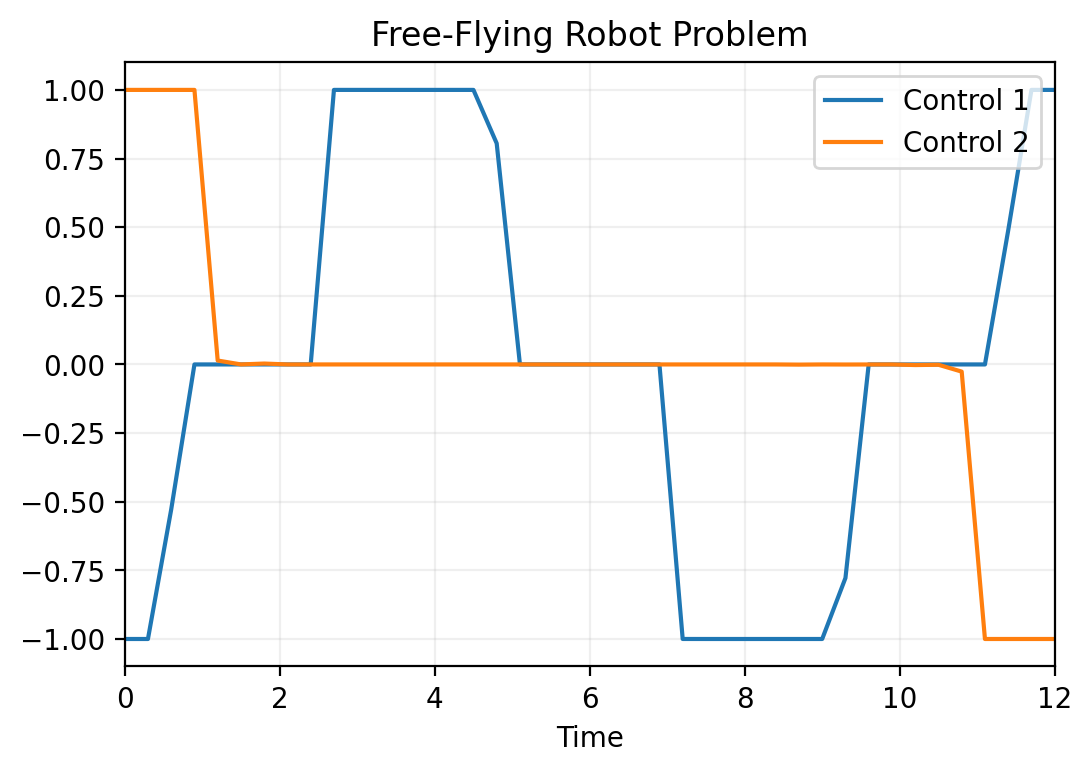

In [ ]:
control_dict = [(0, 'Control 1'), (1, 'Control 2')]
plot_flying_robot_vars(times, states, controls, state_dict=None, control_dict=control_dict)

### Overview of Results

Let's briefly go over the resulting plots. The center of gravity/position variables start from $(-10, -10)$ and end at $(0, 0)$ as expected. The velocities in both coordinates have a similar appearance - increasing and flattening around 2 just before half-time, and after staying there for about two seconds, linearly decreases. What's more interesting is that the velocities in both coordinates "mirror" each other - the robot accelerates more first in the y direction with an initial "bump" (0-2 seconds), the x direction acceleration joins a bit later. In this mirroring fashion, the x direction velocity stays relatively higher than the y direction as they both decrease in the second half, with a final "bump" (9.75-10.5 seconds) in the x-direction. This means the robot first moves mostly vertically, then the vertical movement decreases as horizontal movement becomes more prominent. The illustration shown in the States section in this notebook verifies this. We also see that the angular velocity $\omega$ has a "W" appearance, with a corresponding $\theta$ graph, they both are 0 at $t_f=12$ as required.

The controls $T_1$ and $T_2$ have an almost discrete appearance: at a given time, they only take values from $\{-1, 0, 1\}$ with very quick transitions, except small transient deviations (e.g. around 4.5 and 9 for $T_1$). The Betts' solution, as it decomposes the $T_1$ and $T_2$ to positive and negative components as $T_1 = u_1 - u_2$ and $T_2 = u_3 - u_4$, notes that these decomposed controls have an on-off appearance, aka bang-bang control: $\{0, 1\}$. This is due to the fact that the controls appear linearly in the 4-control problem setting. We instead have the $\{-1, 0, 1\}$ case due to our use of absolute values in the cost function. Betts' book conveniently plots $T_1 = u_1 - u_2$ and $T_2 = u_3 - u_4$ as well, so we are directly able to verify that our estimations of the thruster controls follow the real solutions very closely.



## Conclusion

In this notebook, we have:
1. Introduced Sakawa's Free-Flying Robot problem from Betts' *Practical methods for optimal control using nonlinear programming*
2. Defined the states, controls, dynamics and the cost function of the problem
3. Defined the boundary conditions for the states and controls
4. Implemented the problem in Python
5. Implemented trapezoidal collocation and the corresponding trapezoidal quadrature required to solve the problem via direct transcription
6. Solved the implemented problem using Jax and SciPy's SLSQP solver
7. Demonstrated that our optimal solution converges to the *real* optimal solution as we increase the number of intervals used to approximate the integral
8. Demonstrated that the evolution of our states and controls over time when determined by our transcription method follow the real evolution of the states and controls extremely closely, verifying the validity of our approach and solution.